<a href="https://colab.research.google.com/github/akv2011/Harvard-CS50/blob/main/tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import matplotlib
%pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)



import torch

print_config()

MONAI version: 1.4.dev2425
Numpy version: 1.26.3
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: b5d71491b839191430b236bd3b233c5f29daf229
MONAI __file__: /home/<username>/anaconda3/envs/nit/lib/python3.12/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.1+cu121
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd 

In [ ]:
import json

data = {
    "description": "YOUR DESCRIPTION",
    "labels": {
        "0": "background",
        "1": "pancreas",
        "2": "cancer"
    },
    "licence": "yt",
    "modality": {
        "0": "CT"
    },
    "name": "pancreas",
    "numTest": 2,
    "numTraining": 2,
    "reference": "Megathlon",
    "release": "1.0 06/08/2015",
    "tensorImageSize": "3D",
    "test": [
        "/home/systemx86/Pictures/Tumor_detection/Code_test/Test/pancreas_038.nii",
        "/home/systemx86/Pictures/Tumor_detection/Code_test/Test/pancreas_039.nii",
    ],
    "training": [
        {
            "image": "/home/systemx86/Pictures/Tumor_detection/Code_test/Train/pancreas_135.nii",
            "label": "/home/systemx86/Pictures/Tumor_detection/Code_test/Label/pancreas_135.nii"
        },
        {
            "image": "/home/systemx86/Pictures/Tumor_detection/Code_test/Train/pancreas_149.nii",
            "label": "/home/systemx86/Pictures/Tumor_detection/Code_test/Label/pancreas_149.nii"
        },
    ],
    "validation": [
        {
            "image": "/home/systemx86/Pictures/Tumor_detection/Code_test/Validation/Image/pancreas_334.nii",
            "label": "/home/systemx86/Pictures/Tumor_detection/Code_test/Validation/Label/pancreas_334.nii"
        },
        {
            "image": "/home/systemx86/Pictures/Tumor_detection/Code_test/Validation/Image/pancreas_339.nii",
            "label": "/home/systemx86/Pictures/Tumor_detection/Code_test/Validation/Label/pancreas_339.nii"
        },
    ]
}

with open('dataset_0.json', 'w') as outfile:
    json.dump(data, outfile, indent=2)

print("dataset_0.json has been created.")

dataset_0.json has been created.


In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpos5ghpmn


In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

/home/systemx86/anaconda3/envs/nit/lib/python3.12/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
data_dir = "/home/systemx86/Pictures/Tumor_detection/Code_test/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=2,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

Loading dataset: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


image shape: torch.Size([1, 224, 172, 114]), label shape: torch.Size([1, 224, 172, 114])


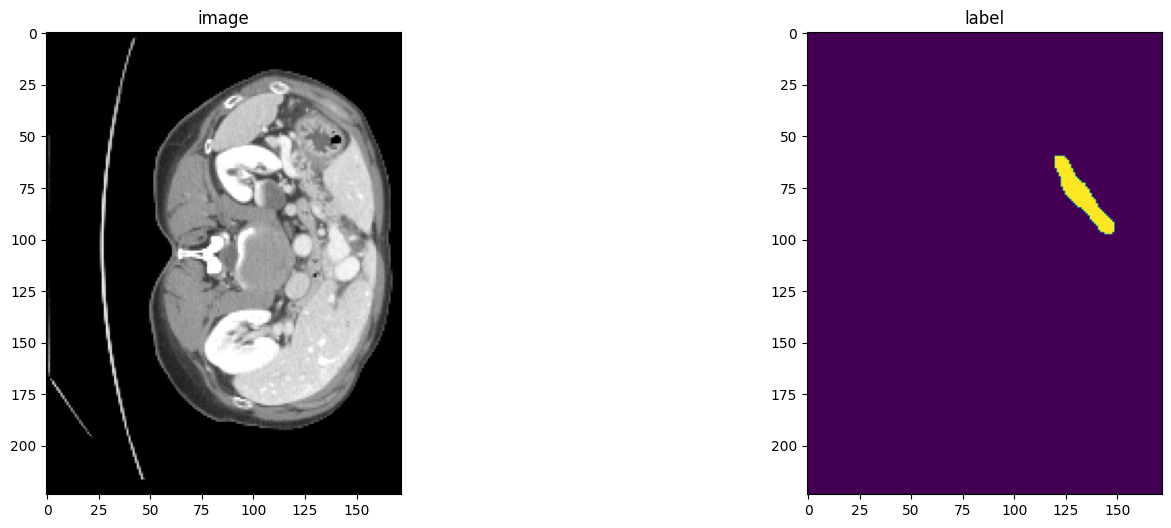

In [ ]:
slice_map = {
    "pancreas_334.nii": 50,
    "pancreas_339.nii":50,

}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [ ]:
import torch; print(torch.cuda.is_available())

True


In [ ]:
import torch

# Clear the GPU cache
torch.cuda.empty_cache()


In [ ]:
import torch
from monai.networks.nets import UNETR
from torch.cuda.amp import autocast, GradScaler  # Added

torch.cuda.empty_cache()

device = torch.device("cuda")

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    proj_type="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = GradScaler()  # Added


In [ ]:
import gc

def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            with autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
        return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
        with autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1

    # Clear GPU cache and force garbage collection at the end of each epoch
    torch.cuda.empty_cache()
    gc.collect()

    return global_step, dice_val_best, global_step_best

max_iterations = 25000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))



Training (X / X Steps) (loss=X.X):   0%|          | 0/2 [00:00<?, ?it/s]


TypeError: list indices must be integers or slices, not str